## 引包

In [1]:
import os
import cv2
import io
import glob
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential, backend
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Concatenate, Lambda, Input, ZeroPadding2D, AveragePooling2D
from keras.utils.np_utils import to_categorical

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import ipywidgets as widgets
from IPython.display import clear_output,display

#调用GPU方法
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
sess = tf.compat.v1.Session(config=config)
# 选择编号为0的GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"#我的笔记本只有一块GPU，编号是0，所以这里调用编号为0的GPU


SEED=6
tf.random.set_seed(SEED)

2022-12-22 15:57:00.197381: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-22 15:57:01.239193: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22320 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:ce:00.0, compute capability: 8.6


## 加载数据

In [2]:
x_train_savepath = '../../../../autodl-tmp/X_train.npy'
y_train_savepath = '../../../../autodl-tmp/Y_train.npy'
x_test_savepath = '../../../../autodl-tmp/X_test.npy'
y_test_savepath = '../../../../autodl-tmp/Y_test.npy'

def load_data():
    #如果数据集数组文件存在, 就直接载入
    if os.path.exists(x_train_savepath) and os.path.exists(y_train_savepath) and os.path.exists(
            x_test_savepath) and os.path.exists(y_test_savepath):
        X_train = np.load(x_train_savepath)
        Y_train = np.load(y_train_savepath)
        X_test = np.load(x_test_savepath)
        Y_test = np.load(y_test_savepath)
    return X_train, Y_train, X_test, Y_test


X_train, Y_train, X_test, Y_test = load_data()

In [3]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("Y_train:", Y_train.shape)
print("Y_test:", Y_test.shape)

X_train: (15360, 224, 224, 3)
X_test: (3840, 224, 224, 3)
Y_train: (15360, 2)
Y_test: (3840, 2)


In [4]:
import re

def is_in(full_str, sub_str):
    if re.findall(sub_str, full_str):
        return True
    else:
        return False

## 搭建模型DenseNet121

In [5]:
# 引入SeNet,增强通道注意力
def senet_block(inputs, ratio):
    shape = inputs.shape
    channel_out = shape[-1]
    # print(shape)
    # (2, 28, 28, 32) , [1,28,28,1], [1,28,28,1]
    squeeze = layers.GlobalAveragePooling2D()(inputs)
    # [2, 1, 1, 32]
    # print(squeeze.shape)
    # 第二层，全连接层
    # [2,32]
    # print(squeeze.shape)
    shape_result = layers.Flatten()(squeeze)
    # print(shape_result.shape)
    # [32,2]
    shape_result = layers.Dense(int(channel_out / ratio), activation='relu')(shape_result)
    # shape_result = layers.BatchNormalization()(shape_result)
    # [2,32]
    shape_result = layers.Dense(channel_out, activation='sigmoid')(shape_result)
    # shape_result = layers.BatchNormalization()(shape_result)

    # 第四层，点乘
    # print('heres2')
    excitation_output = tf.reshape(shape_result, [-1, 1, 1, channel_out])
    # print(excitation_output.shape)
    h_output = excitation_output * inputs
    return h_output



# Conv_Block：卷积单元 BN-RELU-CONV(1X1) —— BN-RELU-CONV(3X3) —— SeNet
def conv_block(x, nb_filter, dropout_rate=None, name=None, r=16):
    
    inter_channel = nb_filter*4

    # 1x1 convolution， 
    # epsilon 将小浮点数添加到方差以避免被零除
    # data_format="channels_first"，(batch_size, channels,height, width)则在BatchNormalization中设置axis=1，默认是channels_last，则设置axis=3
    x = BatchNormalization(epsilon=1.1e-5, axis=3, name=name+'_bn1')(x)
    x = Activation('relu', name=name+'_relu1')(x)
    x = Conv2D(inter_channel, 1, 1, name=name+'_conv1', use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    # 3x3 convolution
    x = BatchNormalization(epsilon=1.1e-5, axis=3, name=name+'_bn2')(x)
    x = Activation('relu', name=name+'_relu2')(x)
    x = ZeroPadding2D((1, 1), name=name+'_zeropadding2')(x)
    x = Conv2D(nb_filter, 3, 1, name=name+'_conv2', use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    
    # 加SE注意力机制
    # x = Squeeze_excitation_layer(r)(x)
    x= senet_block(x, r)
    return x


# Dense_Block 卷积组：由N个卷积单元组构成Dense Block
def dense_block(x, stage, nb_layers, nb_filter, growth_rate, dropout_rate=None, 
                grow_nb_filters=True, name =None, r = 16):

    concat_feat = x # store the last layer output

    for i in range(nb_layers):
        
        branch = i+1
        x =conv_block(concat_feat, growth_rate, dropout_rate, name=name+str(stage)+'_block'+str(branch), r=r) # 在参考的基础，修改的地方这里应该是相同的growth_rate=32
        concat_feat = Concatenate(axis=3, name=name+str(stage)+'_block'+str(branch))([concat_feat, x])

        
        if grow_nb_filters:
            nb_filter += growth_rate

    return concat_feat, nb_filter



# Transition_Block： 每个Dense block之间的传递block，主要用来降低特征层数
def transition_block (x,stage, nb_filter, compression=1.0, dropout_rate=None, name=None):

    x = BatchNormalization(epsilon=1.1e-5, axis=3, name=name+str(stage)+'_bn')(x)
    x = Activation('relu', name=name+str(stage)+'_relu')(x)
    
    x = Conv2D(int(nb_filter*compression), 1, 1, name=name+str(stage)+'_conv', use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    
    x = AveragePooling2D((2,2), strides=(2,2), name=name+str(stage)+'_pooling2d')(x)

    x= senet_block(x, 16)
    return x



# Se-DenseNet: 121
def DenseNet(nb_dense_block=4, growth_rate=32, nb_filter=64, reduction=0.0, dropout_rate=0.0, weight_decay=1e-4, classes=1000, weights_path=None, r=16):

    compression = 1.0-reduction
    nb_filter=64
    nb_layers = [6, 12, 24, 16]  #For DenseNet-121
    
    img_input = Input(shape=(224,224,3))

    #initial convolution
    x = ZeroPadding2D((3, 3), name='conv1_zeropadding')(img_input)        # (3, 3)  s=1
    x = Conv2D(nb_filter, 7, 2, name='conv1', use_bias=False)(x)          # ====(7, 7)  s=2==== Conv2D
    x = BatchNormalization(epsilon=1.1e-5, axis=3, name='conv1_bn')(x)    
    x = Activation('relu', name='relu1')(x)
    x = ZeroPadding2D((1, 1), name='pool1_zeropadding')(x)                # (1, 1)  s=1
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1')(x)             # ====(3, 3 ) s=2==== MaxPooling

    #Dense block and Transition layer
    for block_id in range(nb_dense_block-1):
        stage = block_id+2 # start from 2

        x, nb_filter = dense_block(x, stage, nb_layers[block_id], nb_filter, growth_rate, 
        dropout_rate=dropout_rate, name='Dense', r=r)

        x = transition_block(x, stage, nb_filter, compression=compression, dropout_rate=dropout_rate, name='Trans')
        nb_filter *=compression
    
    final_stage = stage + 1
    x, nb_filter=dense_block(x, final_stage, nb_layers[-1], nb_filter, growth_rate, 
        dropout_rate=dropout_rate, name='Dense')

    # top layer
    x = BatchNormalization(name= 'final_conv_bn')(x)
    x = Activation('relu', name='final_act')(x)
    x = GlobalAveragePooling2D(name='final_pooling')(x)
    # x = Dense(classes, activation='softmax', name='fc')(x)

    model=models.Model(img_input, x, name='DenseNet_SE')

    return model


conv_base = DenseNet(reduction=.5)
path_weights = "../../densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"
conv_base.load_weights(path_weights, by_name=True, skip_mismatch=True)
conv_base.trainable = True

model=conv_base.output

model=tf.keras.layers.Dense(512,activation='relu')(model)
model=tf.keras.layers.Dropout(0.5)(model)
model=tf.keras.layers.Dense(2,activation="softmax")(model)
model=tf.keras.models.Model(inputs=conv_base.input,outputs=model)

model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
model.summary()

tensorboard = TensorBoard(log_dir="AD-MCI-SE-2")
checkpoint = ModelCheckpoint("AD-MCI-SE-2.h5", 
                            monitor='val_accuracy', 
                            mode = "auto", 
                            verbose = 1,
                            save_best_only =True)

2022-12-22 15:57:18.039100: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22320 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:ce:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_zeropadding (ZeroPadding2 (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9408        conv1_zeropadding[0][0]          
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
______________________________________________________________________________________________

2022-12-22 15:57:22.680903: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-22 15:57:22.680965: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-22 15:57:22.681046: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-12-22 15:57:22.681625: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/miniconda3/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-22 15:57:22.954241: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-22 15:57:22.954719: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [6]:
reduce_LR = ReduceLROnPlateau(monitor="val_loss", 
                             factor = 0.5, 
                             patience = 2, 
                             min_delta=0.001, 
                             mode = "auto", 
                            verbose = 1)

In [7]:
history = model.fit(X_train, Y_train,
                  validation_split =0.1,
                  epochs =100, 
                  verbose =1, 
                  batch_size = 32, 
                  callbacks = [tensorboard, checkpoint, reduce_LR])

2022-12-22 15:57:40.633606: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 8323596288 exceeds 10% of free system memory.
2022-12-22 15:57:53.434359: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 8323596288 exceeds 10% of free system memory.
2022-12-22 15:58:00.794544: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-12-22 15:58:24.115825: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8400
2022-12-22 15:58:26.602891: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


  1/432 [..............................] - ETA: 3:17:59 - loss: 0.7303 - accuracy: 0.4688

2022-12-22 15:58:29.180693: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-22 15:58:29.180749: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/432 [..............................] - ETA: 17:38 - loss: 0.9525 - accuracy: 0.5156  

2022-12-22 15:58:30.868540: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-22 15:58:30.869323: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-22 15:58:30.977435: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 4621 callback api events and 4642 activity events. 
2022-12-22 15:58:31.158511: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-22 15:58:31.317057: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: AD-MCI-SE-2/train/plugins/profile/2022_12_22_15_58_31

2022-12-22 15:58:31.438976: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to AD-MCI-SE-2/train/plugins/profile/2022_12_22_15_58_31/autodl-container-953911983c-76901fc6.trace.json.gz
2022-12-22 15:58:31.661198: I tensorflow/core/profiler/rpc/client/save_profile.cc:

432/432 [==============================] - 95s 156ms/step - loss: 0.6867 - accuracy: 0.5681 - val_loss: 0.7315 - val_accuracy: 0.4987

Epoch 00001: val_accuracy improved from -inf to 0.49870, saving model to AD-MCI-SE-2.h5
Epoch 2/100
432/432 [==============================] - 65s 150ms/step - loss: 0.6654 - accuracy: 0.6006 - val_loss: 0.6875 - val_accuracy: 0.5566

Epoch 00002: val_accuracy improved from 0.49870 to 0.55664, saving model to AD-MCI-SE-2.h5
Epoch 3/100
432/432 [==============================] - 61s 142ms/step - loss: 0.6600 - accuracy: 0.6113 - val_loss: 0.6613 - val_accuracy: 0.6003

Epoch 00003: val_accuracy improved from 0.55664 to 0.60026, saving model to AD-MCI-SE-2.h5
Epoch 4/100
432/432 [==============================] - 64s 147ms/step - loss: 0.6493 - accuracy: 0.6223 - val_loss: 0.7413 - val_accuracy: 0.5801

Epoch 00004: val_accuracy did not improve from 0.60026
Epoch 5/100
432/432 [==============================] - 59s 136ms/step - loss: 0.6398 - accuracy: 0.

In [8]:
def accuracy_lr_loss_plot (history):
    fig = plt.figure(figsize=(15,10))
    
    plt.subplot(221)
    plt.plot(history.history["loss"], "bo--", label="loss")
    plt.plot(history.history["val_loss"], "ro--", label = "val_loss")
    plt.title("Training Data Loss")
    plt.xlabel("Number of epochs")
    plt.ylabel("loss")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(222)
    plt.plot(history.history["accuracy"], 'bo--', label="accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label="val_accuracy")
    plt.title("Training Data Accuracy Measurements")
    plt.xlabel("Number of epochs")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
   
    
    plt.show()

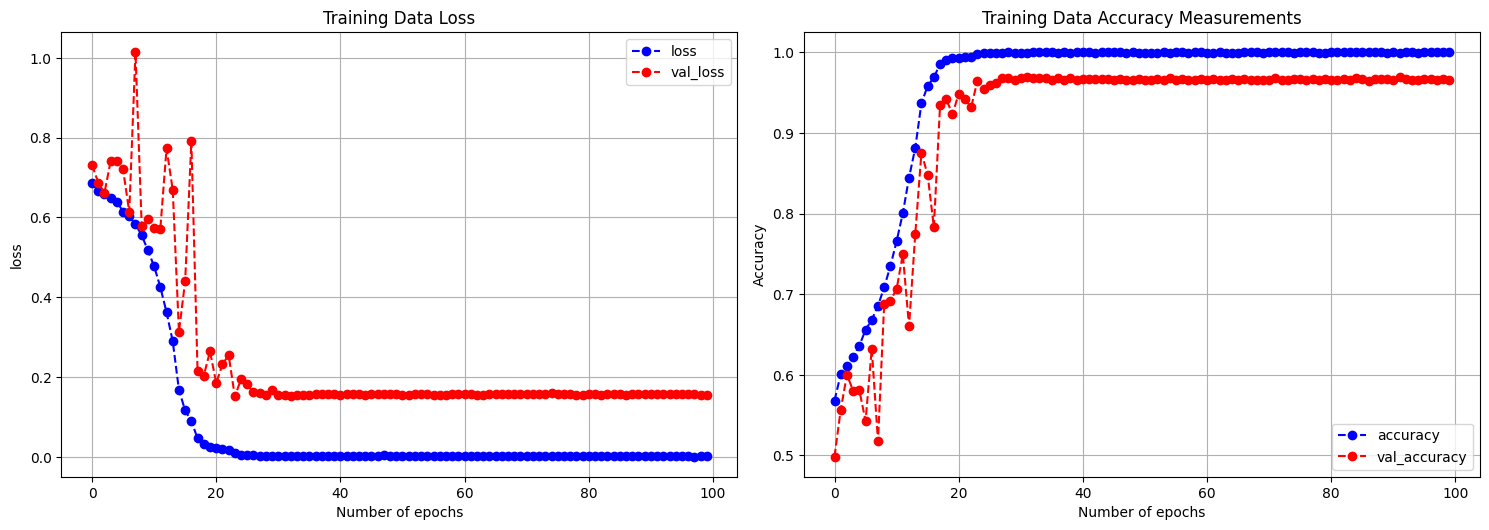

In [9]:
accuracy_lr_loss_plot(history)

In [10]:
result= model.evaluate(X_test,Y_test,batch_size=32)
print("Accuracy is\n",result)

# dataFrame = pd.DataFrame({"loss":result[0], "accuracy":result[1]}, index=[0])

# dataFrame.to_csv("AD-CN-Classification.csv", index=False, mode="a")

# dataFrame.to_csv("AD-CN-Classification.csv", index=False, mode="a", header=False)


120/120 [==============================] - 5s 40ms/step - loss: 0.1164 - accuracy: 0.9742
Accuracy is
 [0.11638530343770981, 0.9742187261581421]


### 绘制混淆矩阵及特异-敏感性分析

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

labels = ["AD", "MCI"]

y_pred = model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_test_new = np.argmax(Y_test, axis=1)
target_names = labels

In [12]:
print(classification_report(y_test_new, y_pred,target_names=target_names))

              precision    recall  f1-score   support

          AD       0.97      0.98      0.97      1891
         MCI       0.98      0.97      0.97      1949

    accuracy                           0.97      3840
   macro avg       0.97      0.97      0.97      3840
weighted avg       0.97      0.97      0.97      3840



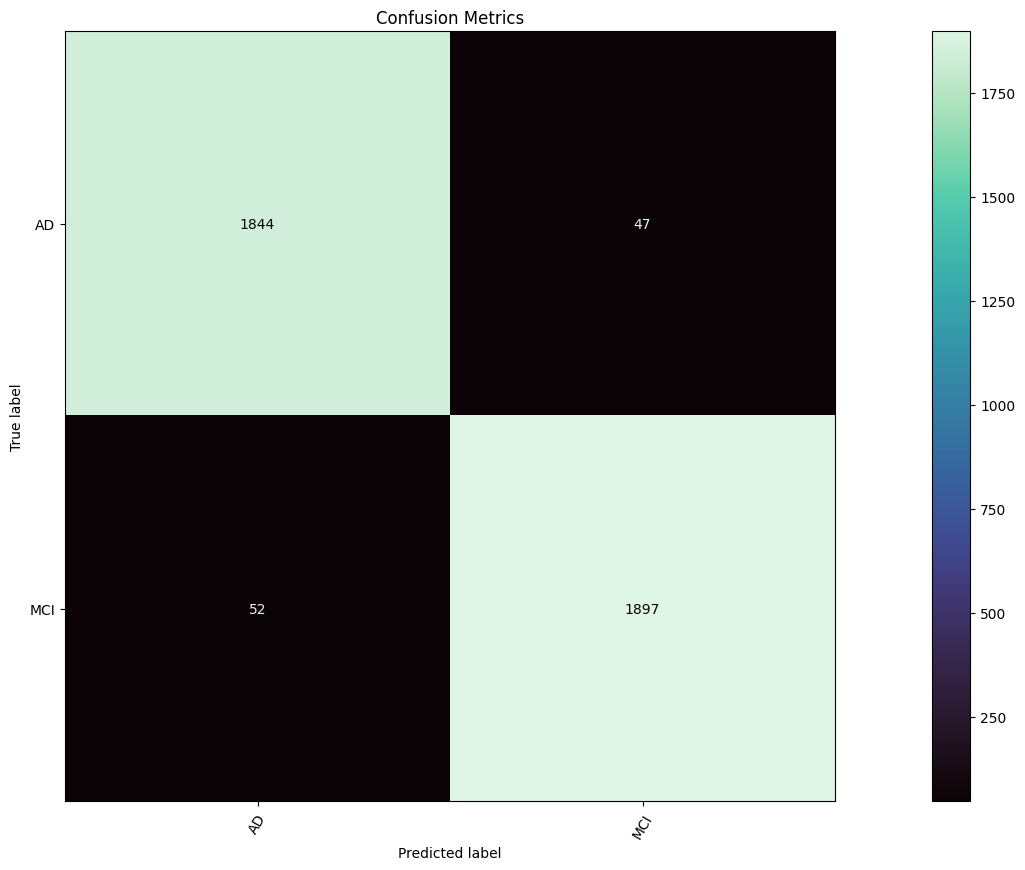

In [13]:
cm=confusion_matrix(y_test_new, y_pred)
display_c_m = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(25,10)) 
display_c_m.plot(cmap='mako',ax=ax,xticks_rotation=60)
plt.title("Confusion Metrics")
plt.show()

In [14]:
Sensitivity = cm[0][0] / (cm[0][0] + cm[0][1])
Specificity = cm[1][1] / (cm[1][0] + cm[1][1])
print("Sensitivity: " + str(Sensitivity))
print("Specificity: " + str(Specificity))

Sensitivity: 0.9751454257006875
Specificity: 0.9733196511031298


In [15]:
# 在医学统计里，任何一个诊断指标，都有两个最基本的特征，即敏感性和特异性。
# 所谓敏感性，就是指其在诊断疾病的时候不漏诊的机会有多大，所谓特异性就是指该指标在诊断某疾病时，不误诊的机会有多大。
# 单独一个指标，如果提高其诊断的敏感性，必然降低其诊断的特异性，换句话说，减少漏诊必然增加误诊，反之亦然

In [16]:
from sklearn.metrics import precision_recall_fscore_support

res = []
for i in labels:
    prec, recall, _, _ = precision_recall_fscore_support(np.array(y_test_new)==1,
                                                         np.array(y_pred)==1,
                                                         pos_label=True, average=None)
    
    res.append([i, recall[0], recall[1]])

pd.DataFrame(res, columns = ["class", "sensitivity", "specificity"])

,class,sensitivity,specificity
0,AD,0.975145,0.97332
1,MCI,0.975145,0.97332


In [17]:
from sklearn.metrics import accuracy_score,precision_score,recall_score
acc = accuracy_score(y_test_new, y_pred)
pre = precision_score(y_test_new, y_pred, average='macro') 
recall = recall_score(y_test_new, y_pred, average='macro')

print("acc: " + str(acc))
print("pre: " + str(pre))
print("recall: " + str(recall))

acc: 0.97421875
pre: 0.9741984424649686
recall: 0.9742325384019086


### 保存训练的历史记录，方便以后再次画图

In [18]:
# 保存训练的历史记录pickle.dump()
import pickle

history_filename = "AD-MCI-SE-2.json"
with open(history_filename, "wb") as file_json:
    pickle.dump(history.history, file_json)



In [19]:
# 读取保存的训练历史记录
with open(history_filename, "rb") as file_json:
    history_file = pickle.load(file_json)

In [20]:
def accuracy_lr_loss_plot_file (history_file):
    fig = plt.figure(figsize=(15,10))
    
    plt.subplot(221)
    plt.plot(history_file["loss"], "bo--", label="loss")
    plt.plot(history_file["val_loss"], "ro--", label = "val_loss")
    plt.title("Training Data Loss")
    plt.xlabel("Number of epochs")
    plt.ylabel("loss")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(222)
    plt.plot(history_file["accuracy"], 'bo--', label="accuracy")
    plt.plot(history_file['val_accuracy'], 'ro--', label="val_accuracy")
    plt.title("Training Data Accuracy Measurements")
    plt.xlabel("Number of epochs")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
   
    
    plt.show()

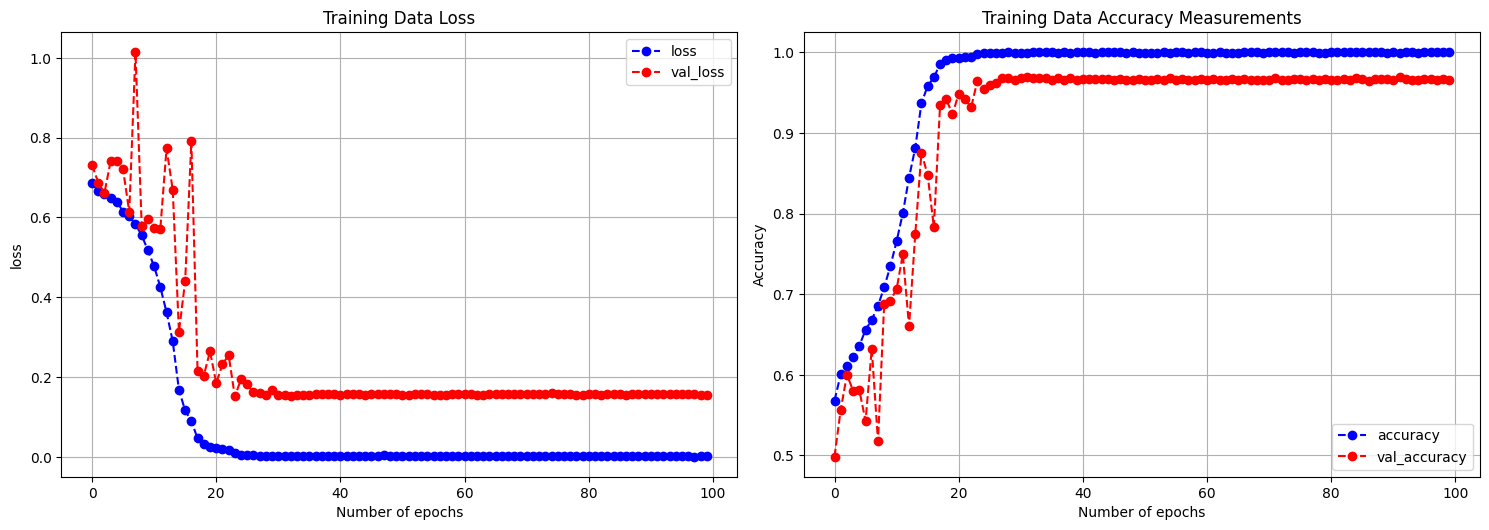

In [21]:
accuracy_lr_loss_plot_file(history_file)